In [1]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random

"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment



"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)
sns.set_style("whitegrid")

# Simulation 


## Setup

In [2]:
# Declare parameters
n_random_agents = 10
n_investor_agents = 1
n_trend_agents = 5
n_mm_agents = 20
n_rl_agents = 0

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

time_periods = 10000

price_list = [100 + np.random.normal() for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99
mean_sell_price = 101
delta = 1

state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage}

env = MarketEnvironment(state0)
agents = []

random_agents = [RandomAgent(agent_id = j,
                             delta = delta) for j in range(n_random_agents)]

investor_agents = [InvestorAgent(agent_id = j + n_random_agents,
                                 delta = 0.1,
                                 intensity = 0.01,
                                 price_margin = 0.01) for j in range(n_investor_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = delta) for j in range(n_trend_agents)]

mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                              delta = delta,
                              gamma = 0.01,
                             gamma2 = 1) for j in range(n_mm_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + mm_agents,
                                 delta = delta) for j in range(n_rl_agents)]

agents.append(investor_agents)
agents.append(random_agents)
agents.append(trend_agents)
agents.append(mm_agents)
agents.append(rl_agents)


agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

## Run simulation

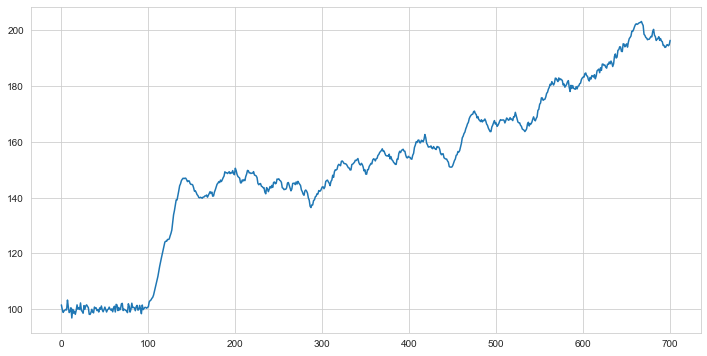

[=============       ] 66%

KeyboardInterrupt: 

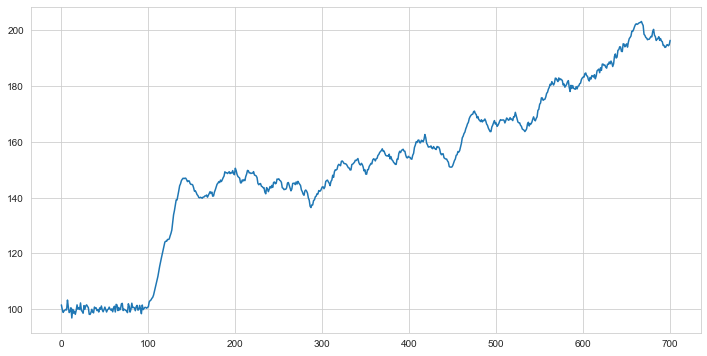

In [3]:
time_periods = 1000
rl_profit = []
market_prices = []

fig, ax = plt.subplots(figsize = (12, 6))


for time in range(time_periods):

    agents, state = env.step(agents)
    
    for j in range(n_agents):
        agents[j].update(state)
    
    
    ########################################
    # PRINT RUNTIME
    ########################################
    
    j = (time + 1) / time_periods
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    
    #########################################
    # UPDATE PLOTS
    #########################################
    
    if time % 100 == 0:
        clear_output()
        ax.cla()
        ax.plot(state["market_prices"])
        display(fig)
        #print("Investor Position", agents[0].position)
        #print("Investor Buy Volume", agents[0].buy_volume)

    
#save_state_space
#agents[n_agents - 1].save_state_space()

[Text(0.5, 1.0, 'Cumulative Returns')]

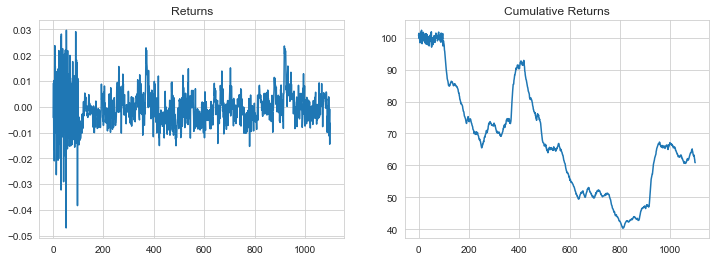

In [4]:
mp = pd.DataFrame(state['market_prices'])
returns = mp / mp.shift(1)  - 1

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(title = "Returns")
ax[1].plot(mp)
ax[1].set(title = "Cumulative Returns")
#plt.savefig("plots/returns_cumreturns.png")

In [128]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)


def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

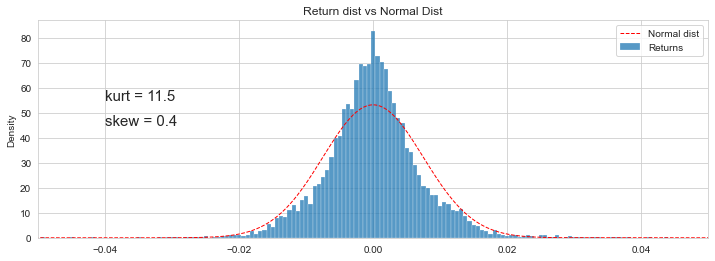

In [129]:
avg = np.nanmean(returns)
std = np.std(returns)[0]
n = len(returns)
x = np.linspace(np.max(returns)[0], np.min(returns)[0], n)
norm_dist = stats.norm.pdf(x, avg, std)
kurt = weighted_kurtosis(returns[1:], wts = np.ones_like(returns[1:]))
skew = weighted_skew(returns[1:], wts = np.ones_like(returns[1:]))
fig, ax = plt.subplots( figsize = (12, 4))

sns.histplot(returns, stat = "density", label = "Returns", ax = ax)
ax.plot(x, norm_dist, label = "Normal dist", ls = "--", color = "red", lw = 1)
ax.legend()
ax.set(title = "Return dist vs Normal Dist", xlim = (-0.05, 0.05))
ax.text(-0.04, 55, f"kurt = {kurt:.1f}", fontsize = 15)
ax.text(-0.04, 45, f"skew = {skew:.1f}", fontsize = 15)
#

plt.savefig("plots/kurtosis_dist.png")

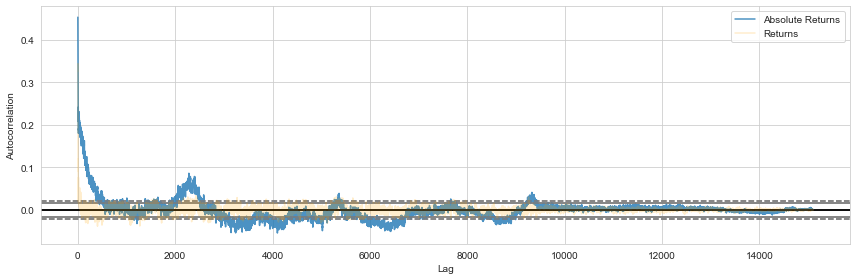

In [130]:

fig, ax = plt.subplots( figsize = (12, 4))

pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax, label = "Absolute Returns", alpha = 0.8)
pd.plotting.autocorrelation_plot(returns[1:], ax = ax, color = "orange", alpha = 0.2, label = "Returns")
fig.tight_layout()
#plt.savefig("plots/autocorel.png")

# Performance overview

In [113]:
ma = pd.Series(state["market_prices"]).rolling(window = 1).apply(lambda x: np.average(x)).dropna()
ma2 = pd.Series(state["market_prices"]).rolling(window = 2).apply(lambda x: np.average(x)).dropna()

107.12528554580867

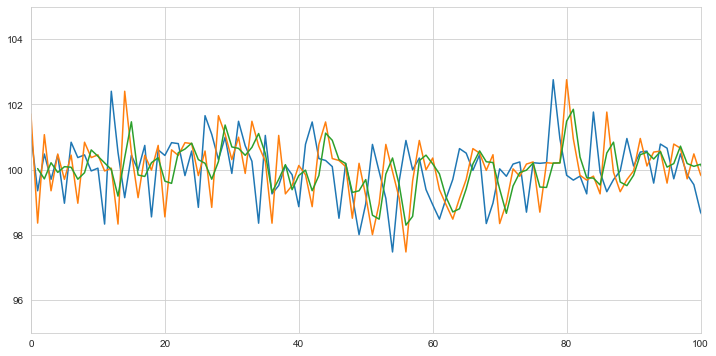

In [114]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(state['market_prices'][2:])
ax.plot(ma)
ax.plot(ma2)
ax.set(xlim=[0,100])
ax.set(ylim=[95,105])
state["market_prices"]
np.maximum(agents[0].sell_price, 0)

In [125]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -6.366462912410498e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
63,63,MM,0.0,5534.881997,0.517489
59,59,MM,-1.0,4717.841923,0.519968
49,49,MM,-1.0,5205.523363,0.583579
61,61,MM,-2.0,4980.668552,0.604862
48,48,MM,1.0,4353.841753,0.617734
53,53,MM,-1.0,4116.067844,0.620428
64,64,MM,-1.0,5251.350186,0.624533
65,65,MM,2.0,4694.628503,0.627101
46,46,MM,1.0,5606.940764,0.642097
55,55,MM,1.0,4404.240867,0.661108


class
Investor    494832.105613
MM            5104.665818
Random      -14950.222874
Trend          216.698598
Name: PNL, dtype: float64